In [45]:
import numpy as np
import sympy as sp
import math as m
from matplotlib import pyplot as plt 
from matplotlib import cm
from numpy import unravel_index
import pygmo as pg

In [46]:
x, y = sp.symbols('x y')

# ~ # функция
# ~ def func(x): 
    # ~ return -x[0]**2-(x[0]+x[1])**2

# ~ # другая функция
# ~ def func2extr(x):
    # ~ return -3*x[0]**2 - 4*x[1]**2 - 23 * m.cos(x[0] - 0.5)

func_x2xy2 = -x ** 2 - (x + y) ** 2
func_2extr = -3 * x ** 2 - 4 * y ** 2 - 23 * sp.cos(x - 0.5)

def sym2call(sympy_function):
    inner_fun = sp.lambdify(((x, y)), sympy_function, modules = ['numpy'])
    def fun(x_vect):
        return inner_fun(x_vect[0], x_vect[1])

    return fun

# ~ def xy_call(xy_fun, arg_list):
    # ~ return xy_fun(
        # ~ arg_list[0],
        # ~ arg_list[1]
    # ~ )

# функция-обёртка, вычисляющая значения переадваемой ф-ции в каждой точке передаваемой сетки
def func_mesh(sympy_function, xlist):
    sizes = [
        xlist[0].shape[0],
        xlist[0].shape[1],
    ]

    # ~ print('shape: ', sizes)
    
    res_list = np.zeros((
        sizes[0],
        sizes[1],
    ))

    call_fun = sym2call(sympy_function)

    # проходь по всем точкам сетки
    for xi in range(0, sizes[0]):
        for yi in range(0, sizes[1]):
            arg = [
                xlist[0][yi][xi],
                xlist[1][yi][xi]
            ] 

            res_list[yi, xi] = call_fun(
                # ~ xlist[0][yi][xi], xlist[1][yi][xi]
                arg
            )
            
    print("Finished building list of values")
    return res_list


In [47]:
# ф-ция поиска градиенту
def grad(sympy_function, x_vect, step = 0.00001):
    # ~ arr = np.empty(x.size)
    # ~ for i in range(0, x.size):
        # ~ x2 = np.copy(x)
        # ~ x2[i] += step
        # ~ arr[i] = (func_name(x2) - func_name(x)) / step
    # ~ call_fun = sym2call(sympy_function)
    arr = [
        sym2call(sympy_function.diff(x)) (x_vect),
        sym2call(sympy_function.diff(y)) (x_vect),
    ]
    
    return np.array(arr)

def vect_length(arr):
    res = 0
    for i in range(0, arr.size):
        res += arr[i] ** 2
    return res ** 0.5



In [48]:
# ---------------------- градиентные методы ------------------------------------
def Nu(t:int, a:float, exp:bool = False, T:int = 0):
    if T > 0:
        if exp:
            return a * np.exp(-t / T)
        return a * (1 - t / T)
    elif exp:
        return np.exp(-a * t ** 2)
    return a / t
    
def impulse_gradient_descent_alg(
    sympy_function,
    xk, tk = 1,
    eps = 0.00001,
    iterMax = 1000,
    find_min = False,
    moment = True,
    etta = 0.5,
    T = 0,
    exp = False
):
    call_fun = sym2call(sympy_function)
    
    x = [xk[0]]
    y = [xk[1]]
    z = [call_fun(xk)]
    u0 = 0
    if find_min:
        tk = -tk
        etta = -etta
        
    nu = tk
    
    for i in range(1, int(iterMax)):
        nu = Nu(i, tk, exp, T)

        if moment:
            gradient = grad(sympy_function, xk - etta * u0)
        else:
            gradient = grad(sympy_function, xk)
            
        u0 = etta * u0 + scalar_multiply(nu, gradient)
        xk = xk + u0

        x.append(xk[0])
        y.append(xk[1])
        z.append(call_fun(xk))
        
        if np.linalg.norm(grad(sympy_function, xk)) < eps:
            break

    print("Iterations: ", i)
    
    return [x, y, z]


def adamapt_gradient_descent_alg(
    sympy_function,
    xk, tk = 1,
    eps = 0.00001,
    iterMax = 1000,
    find_min = False,
    eps2 = 0.001, 
    beta1 = 0.9, beta2 = 0.999
):
    call_fun = sym2call(sympy_function)
    x = [xk[0]]
    y = [xk[1]]

    z = [call_fun(xk)]
    if find_min:
        tk = -tk
        
    nu = tk
    
    m = np.zeros(len(xk))
    v = np.zeros(len(xk))
    for i in range(1, int(iterMax)):
        # ~ nu = Nu(i, tk, exp, T)
        
        g = grad(sympy_function, xk)
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * (g ** 2)
        mHigh = m / (1 - beta1 ** (i + 1))
        vHigh = v / (1 - beta2 ** (i + 1))
        xk = xk + nu / (np.sqrt(vHigh + eps2)) * mHigh
        
        x.append(xk[0])
        y.append(xk[1])
            
        z.append(call_fun(xk))

        if np.linalg.norm(grad(sympy_function, xk)) < eps:
            break
    
    print("Iterations: ", i)

    return [x, y, z]

# абычный алгоритм градиентного спуска
# возвращает точки, которые над нарисовать на граффффике
def regular_gradient_descent_alg(
    sympy_function,
    xk, tk = 1,
    eps = 0.00001,
    iterMax = 1000,
    find_min = False
):
    call_fun = sym2call(sympy_function)
    
    all_points = [[], [], []]
    all_points[0].append(xk[0])
    all_points[1].append(xk[1])
    all_points[2].append(call_fun(xk))
    i = 0
    
    while True:
        gradient = grad(sympy_function, xk)
        
        new_xk = np.empty(0)
        if find_min:
            new_xk = subtract_vectors(xk, tk * gradient)
        else:
            new_xk = np.add(xk, tk * gradient)
        
        all_points[0].append(new_xk[0])
        all_points[1].append(new_xk[1])
        all_points[2].append(call_fun(new_xk))
        
        if vect_length(subtract_vectors(new_xk, xk)) < eps: #проверяем, что соседние точки достаточно близки, чтобы остановиться
            break

        # если мы перелетели, надо возвращаццо с меньшим шагом
        diff = call_fun(new_xk) - call_fun(xk)
        if (diff < 0 and not find_min) or (diff > 0 and find_min): # < 0 for max searching, > 0 for min searching 
            tk /= 2
        xk = new_xk
        i += 1
        
    print("Iterations: ", i)
    return all_points



In [49]:
# кастмоные поерации над векторами ибо зверики не умеют гуглить нумпаевские ф-ции
def add_vectors(v, w):
    return np.array([vi + wi for vi, wi in zip(v, w)])

def subtract_vectors(v, w):
    return np.array([vi - wi for vi, wi in zip(v, w)])

def scalar_multiply(c, v):
    return np.array([c * vi for vi in v])

def pretty_print(points): 
    frmt = "{:.10f}"
    print("f(", frmt.format(points[0][-1]), ", ", frmt.format(points[1][-1]), ") =", frmt.format(points[2][-1]))


Iterations:  62
Iterations:  999
Iterations:  999
Iterations:  250
f( 0.0000248350 ,  -0.0000401838 ) = -0.0000000009
f( 0.0645876541 ,  -0.1045577050 ) = -0.0057691700
f( 0.0696982856 ,  -0.1127944894 ) = -0.0067151338
f( -0.0000004409 ,  -0.0000004404 ) = -0.0000000000
Finished building list of values


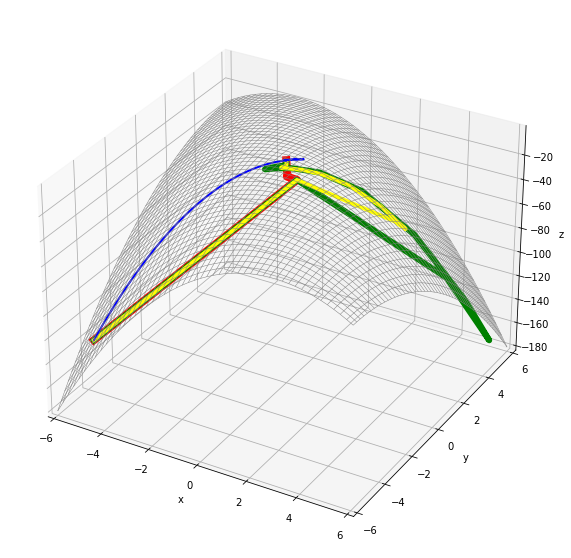

In [50]:
def main(sympy_function, diapason = [-10, 10], x0 = [-1, 1], t0 = 1):
    # поиск пути до т. мин/макс и сохранение точек в пути
    x0 = np.array(x0)

    regular_points = regular_gradient_descent_alg(sympy_function, x0, t0)
    imoment_points = impulse_gradient_descent_alg(sympy_function, x0, t0, iterMax = 1000)
    impulse_points = impulse_gradient_descent_alg(sympy_function, x0, t0, iterMax = 1000, moment = False)
    adamapt_points = adamapt_gradient_descent_alg(sympy_function, x0, t0, iterMax = 1000)
    pretty_print(regular_points)
    pretty_print(imoment_points)
    pretty_print(impulse_points)
    pretty_print(adamapt_points)

    #неавтоматический ввод
    x2 = np.linspace(diapason[0], diapason[1], 50)
    y2 = np.linspace(diapason[0], diapason[1], 50)

    # генерация сетки значений и точек по ним для представления ф-ции 
    xgrid, ygrid = np.meshgrid(x2, y2)
    zgrid = func_mesh(sympy_function, [xgrid, ygrid])

    # поиск мин и макс значения ф-ции что б график не улетал
    maxval = -1000000
    minval =  1000000
    for y in zgrid:
        for x in y:
            if maxval < x:
                maxval = x
            if minval > x:
                minval = x

    fig = plt.figure(figsize = (10, 10))
    ax3d = fig.add_subplot(projection = '3d')

    ax3d.set_xlabel('x')
    ax3d.set_ylabel('y')
    ax3d.set_zlabel('z')

    ax3d.set_xlim3d(diapason[0], diapason[1])
    ax3d.set_ylim3d(diapason[0], diapason[1])
    ax3d.set_zlim3d(minval, maxval)

    # само рисование графиков

    # сама ф-ция красивой сеточкой
    ax3d.plot_wireframe(xgrid, ygrid, zgrid, color = 'gray', linewidth = 0.5)
    # пути до екстремума
    ax3d.plot3D(regular_points[0], regular_points[1], regular_points[2], 'red',    linewidth = 8)
    ax3d.plot3D(imoment_points[0], imoment_points[1], imoment_points[2], 'green',  linewidth = 6)
    ax3d.plot3D(impulse_points[0], impulse_points[1], impulse_points[2], 'yellow', linewidth = 4)
    ax3d.plot3D(adamapt_points[0], adamapt_points[1], adamapt_points[2], 'blue',   linewidth = 2)

    plt.show()

main(
    #func_2extr,         # ф-ция
    func_x2xy2,
    [ -6,   6],         # границы ф-ции
    [ -5,  -5],         # x0
    0.2                 # t0
)

In [51]:
prob = pg.problem(pg.rosenbrock(2))
pop = pg.population(prob=prob, size=1, seed=0)
print(pop.champion_f[0])
scp = pg.algorithm(pg.scipy_optimize(method="L-BFGS-B"))
result = scp.evolve(pop).champion_f
print(result[0])
print(pop.problem.get_fevals())
print(pop.problem.get_gevals())

5616.711446476211
1.2156676337951982e-14
52
51
